In [1]:
import torch
import torch.nn as nn
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D  
from rbf_layer import RBFLayer, l_norm, rbf_gaussian
import traintest as tt
from plot_utils import *
import models
import torch.utils.data as data_utils
import torch.nn.functional as F
import torch.optim as optim
from sklearn import mixture, preprocessing, datasets
from copy import deepcopy
%load_ext skip_kernel_extension
%load_ext autoreload
%autoreload 2

In [3]:
# Generate dataset
data, labels = datasets.make_moons(n_samples=1000, shuffle=True, noise=.15)

df = pd.DataFrame(data, columns=['feature_1', 'feature_2'])
df=(df-df.min())/(df.max()-df.min()) # normalize [0,1]
df['labels'] = labels
data = torch.tensor(df[['feature_1', 'feature_2']].to_numpy(), dtype=torch.float) 
device=torch.device('cuda:0')

<Axes: xlabel='feature_1', ylabel='feature_2'>

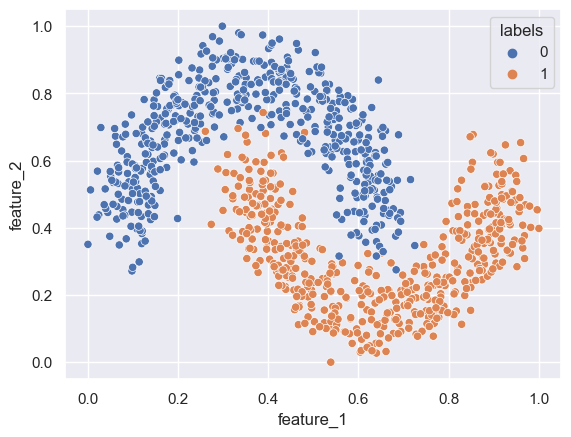

In [4]:
sns.set_theme()
sns.scatterplot(x = df.feature_1, y = df.feature_2, hue = df.labels)

In [5]:
n_centers = 10
gmm = models.GMM(n_centers ,2)
zs = gmm.find_solution(data,iterate=True, collect_z=True)

C:\Users\samle\.conda\envs\CCU\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samle\.conda\envs\CCU\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [6]:
df2 = pd.DataFrame(gmm.mu.detach(), columns=['feature_1', 'feature_2'])
df2['labels'] = ['gmm_center']*n_centers

In [7]:
# make grid for contour
x = y = np.arange(-.03, 1.03, 0.01)
points = []
for xx in x:
    for yy in y:
        points.append([xx, yy])

<Axes: xlabel='feature_1', ylabel='feature_2'>

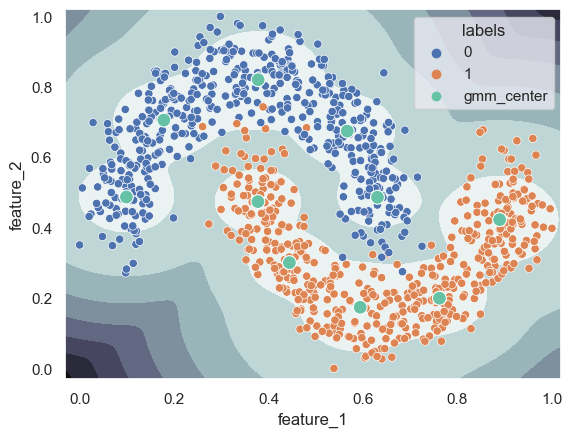

In [8]:
z = torch.logsumexp(gmm(torch.tensor(points)), dim=0).detach().view(len(x), len(y)).T
plt.contourf(x,y,z, cmap=plt.cm.bone)
sns.scatterplot(data = df, x = 'feature_1', y = 'feature_2', hue = 'labels')
sns.scatterplot(data = df2, x = 'feature_1', y = 'feature_2', hue = 'labels', palette='Set2', s = 100)
# sns.scatterplot(data = pd.concat([df, df2], axis=0), x = 'feature_1', y = 'feature_2', hue = 'labels')

In [9]:
#avoid running this cell if not wanting to create animation
%%skip True
animate_em(zs,x,y,df)

UsageError: Line magic function `%%skip` not found.


### MLP Classifier

In [10]:
label = torch.tensor(labels, dtype=torch.int64)
train = data_utils.TensorDataset(data, label)
train_loader = data_utils.DataLoader(train, batch_size=250, shuffle=True)

In [11]:
class TwoMoonsNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 2)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

lr = 0.1
lr_gmm = 1e-3
decay = 5e-4

net = TwoMoonsNet()
param_groups = [{'params':net.parameters(),'lr':lr, 'weight_decay':decay}]
loss = []
acc = []
optimizer = optim.Adam(param_groups)

for epoch in range(200):
    
    l,a,_= tt.train_plain(net.to(device), device, train_loader, optimizer, 
                epoch, verbose=-1)
    loss.append(l)
    acc.append(a)
    if a > .98:
        break # converged

Text(0.5, 0, 'Epoch')

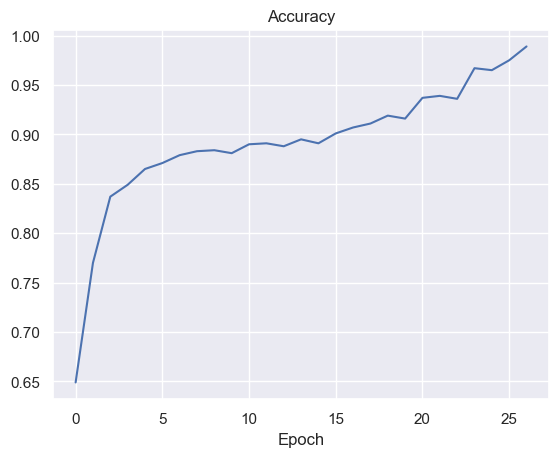

In [12]:
sns.lineplot(acc)
plt.title('Accuracy')
plt.xlabel('Epoch')

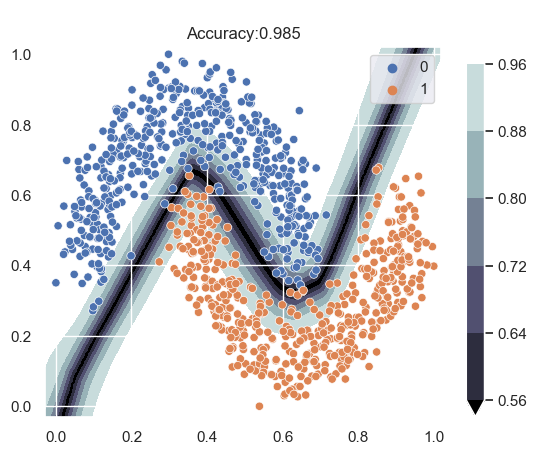

In [13]:
plot_conf(net, data, label, device=device)

### CCU Robust Model Learning

In [14]:
gmm = models.GMM(n_centers ,2)
gmm.find_solution(data,iterate=True)

C:\Users\samle\.conda\envs\CCU\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samle\.conda\envs\CCU\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [15]:
gmm.mu.requires_grad_(False) # turn of learning of centers

Parameter containing:
tensor([[0.8892, 0.4228],
        [0.3780, 0.8202],
        [0.4442, 0.3006],
        [0.0991, 0.4870],
        [0.6306, 0.4862],
        [0.5940, 0.1737],
        [0.3775, 0.4739],
        [0.7618, 0.1995],
        [0.5667, 0.6742],
        [0.1784, 0.7055]])

In [16]:
data_out = torch.rand(1000, 2, dtype=torch.float)
label_out = torch.zeros(1000, dtype=torch.int64)


train_out = data_utils.TensorDataset(data_out, label_out)
train_loader_out = data_utils.DataLoader(train_out, batch_size=250, shuffle=True)

In [17]:
CCU = models.RobustModel(deepcopy(net), deepcopy(gmm), 0.0, dim=2,classes=2)
lr_gmm = 1e-4
param_groups = [{'params':CCU.base_model.parameters(),'lr':lr, 'weight_decay':decay},
               {'params':CCU.mm.parameters(),'lr':lr_gmm, 'weight_decay':0.},
               ] 
loss = []
acc = []
optimizer = optim.Adam(param_groups)

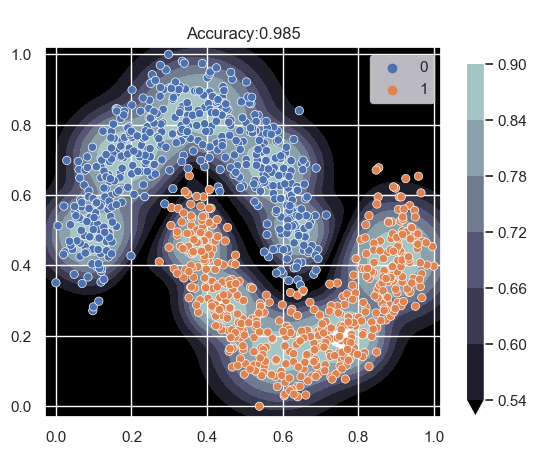

In [18]:
plot_conf(CCU.to(device), data, label, device=device)

In [19]:
%%skip True
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
plt.subplots_adjust(bottom=.09, top=.87,left=.05,wspace=.25,right=.95)
plot_conf(CCU.base_model.to(device), data, label,
             ax1, device=device, title='Base MLP')
plot_conf(CCU.to(device), data, label,
             ax2, device=device, title='CCU')
plt.savefig('Base_Vs._CCU_Confidence.png')

## RBFNet Classifier

In [20]:
# Define an RBF layer where the dimensionality of the input feature is 2,
# the number of kernels is 3, and 2 output features

# euclidean norm
def euclidean_norm(x, p=2, dim=-1):
    return torch.norm(x, p=p, dim=dim)


# Gaussian RBF
def rbf_gaussian(x):
    return (-x.pow(2)).exp()


class TwoMoonsRBFNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.rbf = RBFLayer(in_features_dim=2,
                               num_kernels=10,
                               out_features_dim=10,
                               radial_function=rbf_gaussian,
                               norm_function=euclidean_norm,
                               normalization=True)
        self.fc1 = nn.Linear(10, 2)
        
    def forward(self, x):
        x = F.relu(self.rbf(x))
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)
device=torch.device('cuda:0')

In [21]:
lr = 0.1
decay = 5e-4

net = TwoMoonsRBFNet()
param_groups = [{'params':net.parameters(),'lr':lr, 'weight_decay':decay}]

optimizer = optim.Adam(param_groups)
rbf_tracker = [deepcopy(net.rbf)]
for epoch in range(100):
    tt.train_plain(net.to(device), device, train_loader, optimizer, 
                    epoch, verbose=-1)
    rbf_tracker.append(deepcopy(net.rbf)) # track each step to watch kernels in animation

In [22]:
%%skip True
plot_conf(net, data, label, device=device, title='RBFNN')
plt.savefig('RBFNN_conf.png')

In [23]:
kernels = net.rbf.get_kernels_centers.data.cpu()
kernels

tensor([[-0.3778, -0.5985],
        [ 0.6408,  0.9530],
        [-0.3841, -0.6071],
        [-0.3672, -0.5912],
        [ 1.0539, -0.3264],
        [ 1.1435, -0.3788],
        [ 0.6418,  0.4744],
        [-0.7962, -0.1262],
        [-0.2643,  0.5219],
        [-0.3762, -0.5968]])

<Axes: title={'center': 'Learnt kernels'}, xlabel='feature_1', ylabel='feature_2'>

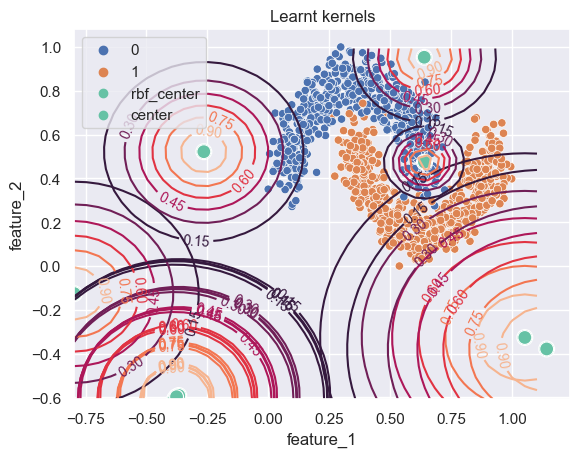

In [24]:
kernel_map(net.rbf, df)
sns.scatterplot(x=kernels[:,0], y=kernels[:,1],palette='Set2', s = 100, hue=np.array(['center']).repeat(len(kernels)))

In [25]:
%%skip True
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
plt.subplots_adjust(bottom=.09, top=.95,left=.08,wspace=.15,right=.99)
kernel_map(net.rbf, df, ax = ax1)
sns.scatterplot(x=kernels[:,0], y=kernels[:,1],palette='Set2', s = 100, hue=np.array(['rbf_center']).repeat(len(kernels)), ax=ax1)
z = torch.logsumexp(gmm(torch.tensor(points)), dim=0).detach().view(len(x), len(y)).T
cont = ax2.contourf(x,y,z, cmap=plt.cm.bone)
sns.scatterplot(data = df, x = 'feature_1', y = 'feature_2', hue = 'labels', ax = ax2)
sns.scatterplot(data = df2, x = 'feature_1', y = 'feature_2', hue = 'labels', palette='Set2', s = 100, ax = ax2)
ax2.title.set_text(f'GMM likelihood')
plt.savefig('RBF_Vs_GMM_Centers.png')

In [26]:
%%skip True
animate_rbf(rbf_tracker, df)

## RBF with CCU (with GMM and RBF seperate)

In [29]:
CCU = models.RobustModel(deepcopy(net), deepcopy(gmm), 0.0, dim=2,classes=2)
lr_gmm = 1e-4
param_groups = [{'params':CCU.base_model.parameters(),'lr':lr, 'weight_decay':decay},
               {'params':CCU.mm.parameters(),'lr':lr_gmm, 'weight_decay':0.},
               ] 
loss = []
acc = []
optimizer = optim.Adam(param_groups)

In [30]:
plot_conf(CCU,data, label, device)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

### Compare RBF output to GMM output

In [22]:
sample = torch.tensor([[.4,.4],[.7,.8]])
net.to('cpu')

TwoMoonsRBFNet(
  (rbf): RBFLayer()
  (fc1): Linear(in_features=10, out_features=2, bias=True)
)

In [23]:
net.rbf(sample) # rbf has 10 centers, gives distance from each center row wise

tensor([[-2.5071e-06,  1.1493e-01,  4.5362e-06, -1.6581e-07, -1.6566e-02,
          6.9531e-01, -4.2540e-06,  1.0833e+00,  1.6067e-01, -1.5573e-06],
        [-2.4903e-06,  8.7726e-01,  8.8282e-06,  7.6328e-09, -1.2541e-02,
         -5.8705e-01, -4.6684e-06, -1.8421e-01,  1.1645e+00, -4.2367e-06]],
       grad_fn=<SumBackward1>)

In [24]:
rc = net.rbf.get_kernels_centers
rvar = net.rbf.get_shapes
rw = net.rbf.get_weights

In [25]:
rc

tensor([[ 0.3831, -0.3599],
        [ 1.4096,  0.2196],
        [ 0.5769,  1.2211],
        [-0.3837, -0.5357],
        [-0.3358, -0.6051],
        [-0.0958,  0.4217],
        [-0.5923, -0.3483],
        [-0.3723, -0.5481],
        [-0.5015, -0.4330],
        [ 0.6131,  0.4514]])

In [26]:
gmm(sample)# gmm has 10 centers, gives value in column for likelihood of each point from sample

tensor([[ -8.2381, -32.2459],
        [-20.2039, -67.2012],
        [ -8.6608, -24.1985],
        [  1.2674, -38.6886],
        [ -5.7767,  -6.5254],
        [-27.1914, -11.8234],
        [ -3.4836, -47.1661],
        [-26.2718, -36.2624],
        [ -9.7708,  -5.5756],
        [-16.3306, -89.9504]], grad_fn=<SubBackward0>)

In [27]:
gc = gmm.mu.detach()
gvar = gmm.logvar.detach()
gw = gmm.alpha.detach()

In [28]:
gvar.exp()

tensor([0.0064, 0.0027, 0.0023, 0.0032, 0.0091, 0.0045, 0.0042, 0.0035, 0.0035,
        0.0030])

In [29]:
gw.exp()

tensor([0.1722, 0.0799, 0.0590, 0.0838, 0.2290, 0.0628, 0.0814, 0.0866, 0.0931,
        0.0524])

In [30]:
rvar

tensor([1.9450, 2.4079, 3.0215, 2.2401, 2.1720, 4.9330, 2.2550, 2.2292, 2.2359,
        8.0188])

In [31]:
rw.exp()

tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000],
        [0.8501, 0.6709, 2.6104, 1.0514, 1.0402, 3.2888, 1.0741, 1.0497, 1.0604,
         2.0975],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000],
        [1.0077, 1.0085, 0.9862, 1.0059, 1.0037, 0.9761, 1.0016, 1.0044, 1.0053,
         0.9244],
        [2.9205, 2.8861, 0.4959, 0.9602, 0.9714, 0.5490, 0.9502, 0.9620, 0.9524,
         0.9155],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000],
        [5.3291, 4.1485, 0.7401, 0.9486, 0.9642, 0.4436, 0.9365, 0.9509, 0.9353,
         0.8440],
        [0.8129, 0.6046, 3.5690, 1.0712, 1.0548, 4.7812, 1.1172, 1.0692, 1.0867,
         2.6954],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000]])

<Axes: xlabel='feature_1', ylabel='feature_2'>

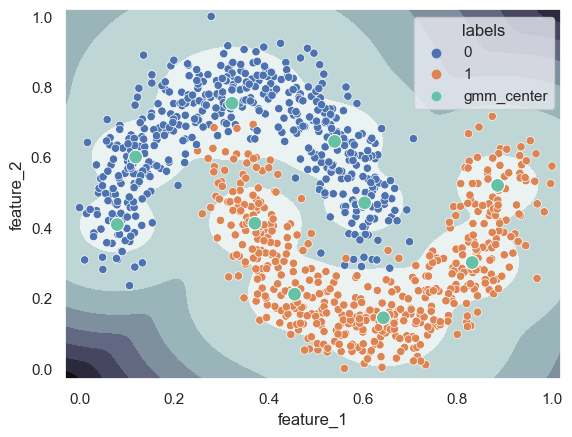

In [32]:
plt.contourf(x,y,z, cmap=plt.cm.bone)
sns.scatterplot(data = df, x = 'feature_1', y = 'feature_2', hue = 'labels')
sns.scatterplot(data = df2, x = 'feature_1', y = 'feature_2', hue = 'labels', palette='Set2', s = 100)

### Combine RBF and GMM centers